In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bayesiankalman import kalmanfilter as kf
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm                    
from scipy import stats

In [115]:
%matplotlib notebook
plt.style.use('seaborn-talk')

In [150]:
log_price = pd.read_hdf('Data/spy_not_downsampled_3sec_2001_2013.hdf', 'table')['2008':'2008']

In [151]:
real_vol = log_price.resample('5min', closed='right').last().groupby(
    pd.TimeGrouper('D')).apply(lambda x : np.sum(np.square(x))).replace(0, np.nan).dropna()
real_vol.columns = ['real_vol']

In [152]:
real_quatricity = log_price.resample('5min', closed='right').last().groupby(
    pd.TimeGrouper('D')).apply(lambda x : np.sum(np.power(x,4))).replace(0, np.nan).dropna()
real_quatricity.columns = ['real_quatricity']

<IPython.core.display.Javascript object>


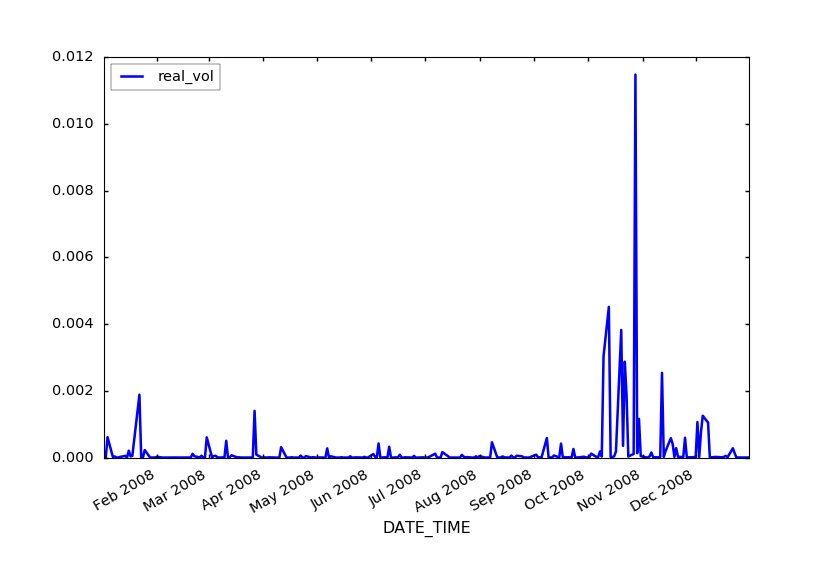

In [153]:
real_vol.plot()

In [70]:
confidence_percentile = 5

In [154]:
num_obs_per_day = np.int(real_vol.groupby(pd.TimeGrouper('D')).resample('5min').last().count())

In [155]:
confidence_region = pd.concat([np.maximum(real_vol.values + stats.norm.ppf(confidence_percentile / 100) *
                                          np.sqrt(2/3 * real_quatricity), 0),
                               real_vol,
                               real_vol.values + stats.norm.ppf((100 - confidence_percentile) / 100) * 
                               np.sqrt(2/3 * real_quatricity)],
                              axis=1)
confidence_region.columns = [str(confidence_percentile) + 'th percentile', 'median', 
                             str(100 - confidence_percentile) + 'th percentile']

<IPython.core.display.Javascript object>


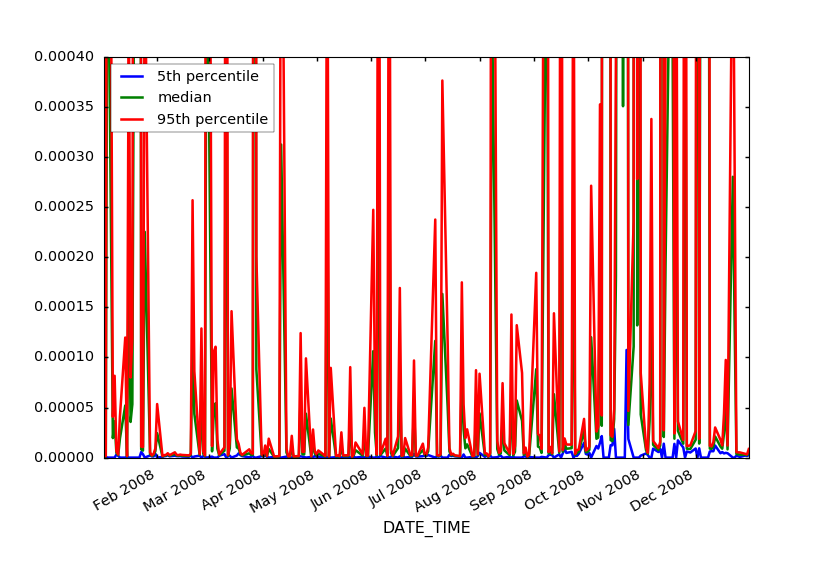

In [156]:
confidence_region.plot(ylim=[0, .0004])

In [161]:
standardized_vol = (real_vol / np.sqrt(real_quatricity.values  * 2/3)).dropna()

In [162]:
np.var(standardized_vol)

real_vol    3.033282
dtype: float64

In [163]:
plt.hist(standardized_vol.values)[-1]

<a list of 10 Patch objects>

In [304]:
def log_like(innov_var, mean_vol, trans1, trans2):
    
    like = kf.kalman_log_like(
        data=real_vol,
        data_loadings=np.asarray([1, 0]),
        state_mean=[mean_vol, 0],
        data_innov_var=2/3 * real_quatricity,
        state_trans=np.asarray([[trans1, trans2],[ 1, 0]]),
        state_innov_var=np.asarray([[innov_var, 0], [0, 0]]),
        time_varying=True
    )
    return like
    
    

In [305]:
log_like(1, 0, 0, 0)

-232.49160822932950055

In [306]:
scaled_mean_vol = np.mean(standardized_vol)

In [307]:
scaled_mean_vol

real_vol    3.18772
dtype: float64

In [308]:
result = minimize(fun=lambda x: -log_like(x[0]**2,x[1], x[2], x[3]), 
                  x0=[1e-4, scaled_mean_vol, .5, 0],
                  method='L-BFGS-B',
                  bounds=[(1e-10, None), (0, None), (-1, 1), (-1, 1)]
                 )

In [309]:
result.x

array([  1.01922458e-06,   5.32981186e-08,   1.12707312e-01,
         8.60175534e-01])

In [310]:
np.mean(real_vol)

real_vol    0.000201
dtype: float64

In [226]:
log_like(1e-10,0,0)

1379.2061729227477826

In [315]:
xvals1 = np.linspace(1e-3, 20, 1000)
yvals1 = [log_like(x,0, .11, .86) for x in  xvals1]

<IPython.core.display.Javascript object>


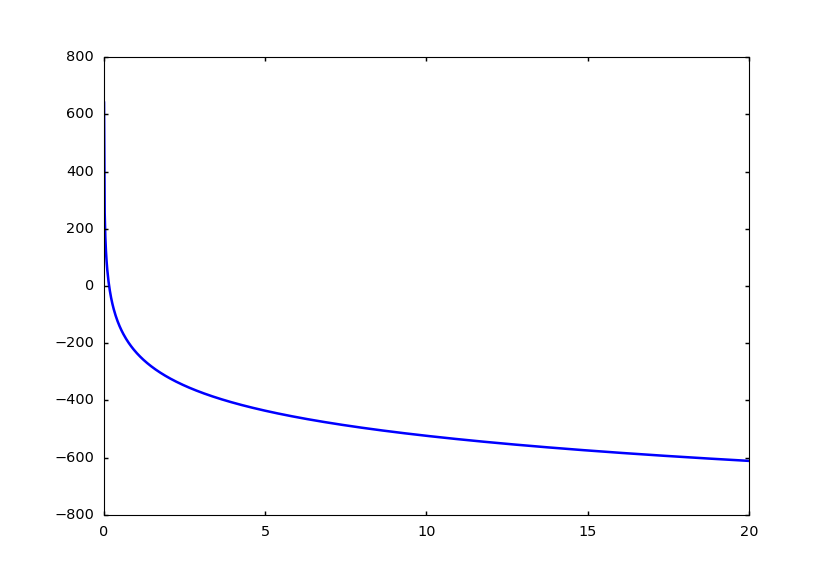

In [316]:
fig, ax = plt.subplots()
ax.plot(xvals1, yvals1)
# ax.set_ylim(-5000, -2000)

In [318]:
xvals2 = np.linspace(1e-2, 5, 100)
zvals2 = [[log_like(x,y, .11, .86) for x in xvals2] for y in xvals2]

<IPython.core.display.Javascript object>


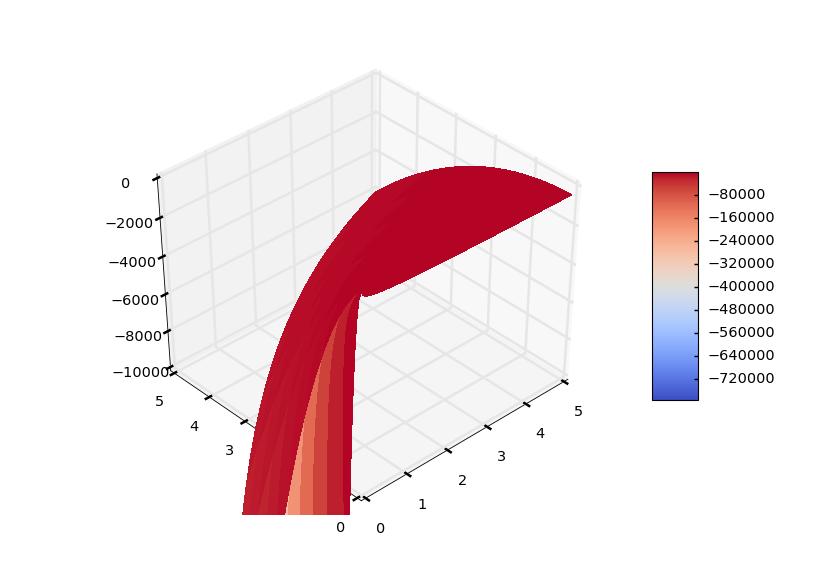

In [319]:
X, Y = np.meshgrid(xvals2, xvals2)
fig2 = plt.figure()
ax3d = fig2.add_subplot(111, projection='3d')
ax3d.set_zlim(-10000, 0)
surf = ax3d.plot_surface(X , Y, Z=zvals2, cmap=cm.coolwarm,                                                 
                       linewidth=0, antialiased=False)                                                
                                                                                                                        
fig2.colorbar(surf, shrink=0.5, aspect=5)       
